In [491]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sns; sns.set_theme()
import os
import glob

def get_files(fn):
    home = os.path.expanduser('~')
    path = f'{home}/Downloads/project_mining_2022/dataset/'
    files = glob.glob(path + fn + '/*.csv')
    return files


def to_date(char):
    return char[:4] + '-' + char[4:6] + '-' + char[6:8]

# for each file create a pandas df
# concatenate them all together
# change index to datetime
def parse_file(files, filenames):
    list_of_pandas = []
    for i, f in enumerate(files):
        # if file empty
        if os.stat(f).st_size != 0:
            # create df
            temp = pd.read_csv(f, header=0, nrows=288, skip_blank_lines=False)
            # create date column
            temp['Date'] = [to_date(filenames[i]) for _ in range(288)]
            # append df 
            list_of_pandas += [temp]
    # cast all together
    df = pd.concat(list_of_pandas, ignore_index=True)
    df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S')
    df.drop(columns=['Date', 'Time'], inplace=True)
    return df

In [439]:
# list files
demand_files = get_files('demand')

# list filenames to use on timestamps
filenames = [file[-12: -4] for file in demand_files]

# get data from files
demands = parse_file(demand_files, filenames)

In [440]:
# interpolate
demands.interpolate(method='linear', axis=0, inplace=True)

In [441]:
demands.head()

,Day ahead forecast,Hour ahead forecast,Current demand
2019-01-01 00:00:00,23437.0,22290.0,22216.0
2019-01-01 00:05:00,22363.0,22089.0,22106.0
2019-01-01 00:10:00,22363.0,22089.0,22130.0
2019-01-01 00:15:00,22363.0,22089.0,22040.0
2019-01-01 00:20:00,22363.0,21867.0,21963.0


In [442]:
import numpy as  np
# (demands.shape[0], window_size, number_of_vars)
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]
def df_to_tensor(data, window_size=5):
    # data = df.to_numpy()
    X = []
    y = []
    for i in range(len(data)-window_size):
        row = [a for a in data[i:i+window_size]]
        label = data[i+window_size][0]
        X.append(row)
        y.append(label)
    return np.array(X), np.array(y)

In [479]:
from sklearn.preprocessing import MinMaxScaler
hours = demands[0::12]
values_to_scale = hours['Current demand'].values.reshape(-1, 1)
print(values_to_scale[17544:17554])
scaler = StandardScaler()
scaled = scaler.fit_transform(values_to_scale)
print(scaled[:7])

[[21937.]
 [20992.]
 [20183.]
 [19713.]
 [19513.]
 [19665.]
 [20237.]
 [20831.]
 [20474.]
 [19562.]]
[[-0.53066612]
 [-0.69060257]
 [-0.83620413]
 [-0.92712832]
 [-0.97320476]
 [-0.93368141]
 [-0.80548651]]


In [444]:
WINDOW_SIZE = 5
X, y = df_to_tensor(scaled, WINDOW_SIZE)
X.shape, y.shape

((26299, 5, 1), (26299,))

In [445]:
X[:2]

array([[[-0.53066612],
        [-0.69060257],
        [-0.83620413],
        [-0.92712832],
        [-0.97320476]],

       [[-0.69060257],
        [-0.83620413],
        [-0.92712832],
        [-0.97320476],
        [-0.93368141]]])

In [446]:
y[:2]

array([-0.93368141, -0.80548651])

In [447]:
# 2 full years per hour data
X_train, y_train = X[:17544], y[:17544]
X_test, y_test = X[17544:25000], y[17544:25000]
X_val, y_val = X[25000:], y[25000:]

In [448]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((17544, 5, 1), (17544,), (7456, 5, 1), (7456,), (1299, 5, 1), (1299,))

In [449]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [450]:
model = Sequential()
model.add(InputLayer((5, 1)))
model.add(LSTM(64))
model.add(Dense(16, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 64)                16896     
                                                                 
 dense_34 (Dense)            (None, 16)                1040      
                                                                 
 dense_35 (Dense)            (None, 1)                 17        
                                                                 
Total params: 17,953
Trainable params: 17,953
Non-trainable params: 0
_________________________________________________________________


In [451]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [452]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

Epoch 1/20
547/549 [============================>.] - ETA: 0s - loss: 0.0959 - root_mean_squared_error: 0.3098

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


549/549 [==============================] - 8s 13ms/step - loss: 0.0958 - root_mean_squared_error: 0.3095 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 2/20
542/549 [============================>.] - ETA: 0s - loss: 0.0117 - root_mean_squared_error: 0.1079

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


549/549 [==============================] - 6s 11ms/step - loss: 0.0116 - root_mean_squared_error: 0.1078 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0953
Epoch 3/20
547/549 [============================>.] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.1015

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


549/549 [==============================] - 6s 11ms/step - loss: 0.0103 - root_mean_squared_error: 0.1015 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0914
Epoch 4/20
545/549 [============================>.] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0981

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


549/549 [==============================] - 6s 11ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 5/20
547/549 [============================>.] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0962

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


549/549 [==============================] - 6s 11ms/step - loss: 0.0092 - root_mean_squared_error: 0.0962 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0863
Epoch 6/20
549/549 [==============================] - 3s 5ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885
Epoch 7/20
549/549 [==============================] - ETA: 0s - loss: 0.0087 - root_mean_squared_error: 0.0934

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


549/549 [==============================] - 6s 11ms/step - loss: 0.0087 - root_mean_squared_error: 0.0934 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0854
Epoch 8/20
549/549 [==============================] - 3s 5ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861
Epoch 9/20
549/549 [==============================] - 3s 5ms/step - loss: 0.0084 - root_mean_squared_error: 0.0917 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880
Epoch 10/20
549/549 [==============================] - 3s 6ms/step - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0862
Epoch 11/20
549/549 [==============================] - 3s 5ms/step - loss: 0.0084 - root_mean_squared_error: 0.0919 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876
Epoch 12/20
544/549 [============================>.] - ETA: 0s - loss: 0.0081 - root_mean_squared_error: 0.0900

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


549/549 [==============================] - 7s 13ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 13/20
549/549 [==============================] - 3s 6ms/step - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 14/20
543/549 [============================>.] - ETA: 0s - loss: 0.0079 - root_mean_squared_error: 0.0888

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


549/549 [==============================] - 7s 12ms/step - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843
Epoch 15/20
549/549 [==============================] - 3s 5ms/step - loss: 0.0078 - root_mean_squared_error: 0.0886 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 16/20
545/549 [============================>.] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.0882

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


549/549 [==============================] - 7s 12ms/step - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822
Epoch 17/20
549/549 [==============================] - 3s 5ms/step - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840
Epoch 18/20
549/549 [==============================] - 3s 5ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837
Epoch 19/20
549/549 [==============================] - 3s 6ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851
Epoch 20/20
549/549 [==============================] - 3s 6ms/step - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860


In [453]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [454]:
def plot(train_loss, validation_loss, label):
    # summarize history for loss
    plt.plot(train_loss)
    plt.plot(validation_loss)
    plt.title(label + ' - Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

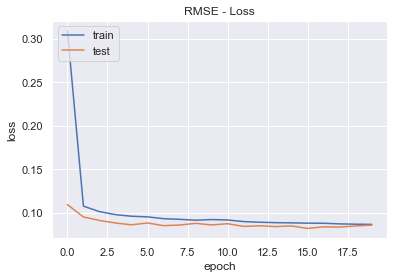

In [455]:
tl, vl = history.history['root_mean_squared_error'], history.history['val_root_mean_squared_error']
plot(tl, vl, 'RMSE')

In [456]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

549/549 [==============================] - 2s 3ms/step


,Train Predictions,Actuals
0,-0.929823,-0.933681
1,-0.776282,-0.805487
2,-0.570790,-0.686916
3,-0.551429,-0.752243
4,-0.880133,-0.909722
...,...,...
17539,-0.618688,-0.587801
17540,-0.688627,-0.781322
17541,-0.907441,-0.946992
17542,-1.053970,-1.043241


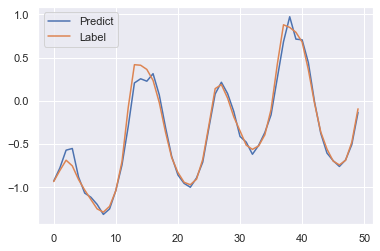

In [462]:
from matplotlib import pyplot as plt
plt.plot(train_results['Train Predictions'][:50], label='Predict')
plt.plot(train_results['Actuals'][:50], label='Label')
plt.legend()
plt.show()

In [458]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

233/233 [==============================] - 1s 3ms/step


,Test Predictions,Actuals
0,-1.031031,-1.053071
1,-0.915078,-0.935934
2,-0.714274,-0.814292
3,-0.670363,-0.887400
4,-1.031939,-1.074163
...,...,...
7451,-0.486340,-0.534557
7452,-0.278676,-0.123760
7453,-0.031015,0.125053
7454,0.106074,0.045597


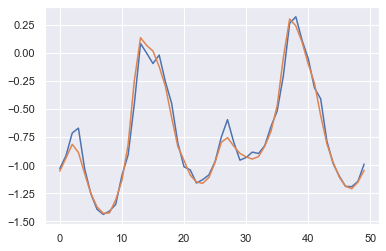

In [490]:
from matplotlib import pyplot as plt
plt.plot(test_results['Test Predictions'][:50], label='Predict')
plt.plot(test_results['Actuals'][:50], label='Label')
plt.show()